LINK TO DATASET: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification/data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, auc, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE


In [2]:
# Read and define the dataset from a csv file into a dataframe
dataset = pd.read_csv('predictive_maintenance.csv')

# Define a mapping dictionary for encoding
type_map = {'L': 0, 'M': 1, 'H': 2}
# Encode the "Type" column using the mapping dictionary
dataset['Type'] = dataset['Type'].map(type_map)

# Define the features and targets
X = dataset.iloc[:, 2:8].values  # FEATURES
y_binary = dataset.iloc[:, 8].values  # BINARY TARGETS OF COLUMN 9

In [3]:
# Separate "not-failed" and "failed" samples
not_failed_indices = np.where(y_binary == 0)[0]
failed_indices = np.where(y_binary == 1)[0]

# Split "not-failed" samples
X_not_failed_train, X_not_failed_temp, y_not_failed_train_binary, y_not_failed_temp_binary = train_test_split(
    X[not_failed_indices], y_binary[not_failed_indices], test_size=0.2, random_state=42)

# Split "failed" samples
X_failed_train, X_failed_temp, y_failed_train_binary, y_failed_temp_binary= train_test_split(
    X[failed_indices], y_binary[failed_indices], test_size=0.2, random_state=42)


In [4]:
# Combine train data for both "not-failed" and "failed" samples
X_train = np.concatenate((X_not_failed_train, X_failed_train))
y_train_binary = np.concatenate((y_not_failed_train_binary, y_failed_train_binary))

In [5]:
# Split the remaining "not-failed" samples for validation and test
X_not_failed_val, X_not_failed_test, y_not_failed_val_binary, y_not_failed_test_binary = train_test_split(
    X_not_failed_temp, y_not_failed_temp_binary, test_size=0.5, random_state=42)

# Combine "failed" samples for validation and test
X_failed_val, X_failed_test, y_failed_val_binary, y_failed_test_binary = train_test_split(
    X_failed_temp, y_failed_temp_binary, test_size=0.5, random_state=42)

In [6]:
# Combine validation data
X_val = np.concatenate((X_not_failed_val, X_failed_val))
y_val_binary = np.concatenate((y_not_failed_val_binary, y_failed_val_binary))

# Combine test data
X_test = np.concatenate((X_not_failed_test, X_failed_test))
y_test_binary = np.concatenate((y_not_failed_test_binary, y_failed_test_binary))

In [7]:
# Apply SMOTE on the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_binary_resampled = smote.fit_resample(X_train, y_train_binary)

In [8]:
# Calculate mean and standard deviation of training data
X_train_mean = np.mean(X_train_resampled, axis=0)
X_train_std = np.std(X_train_resampled, axis=0)

# Normalize training, validation, and test data
X_train_normalized = (X_train_resampled - X_train_mean) / X_train_std
X_val_normalized = (X_val - X_train_mean) / X_train_std
X_test_normalized = (X_test - X_train_mean) / X_train_std

In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_binary_tensor = torch.tensor(y_train_binary_resampled, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
y_val_binary_tensor = torch.tensor(y_val_binary, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_binary_tensor = torch.tensor(y_test_binary, dtype=torch.float32).view(-1, 1)

In [10]:
# Create TensorDataset for train, validation, and test sets for binary classification
train_dataset_binary = TensorDataset(X_train_tensor, y_train_binary_tensor)
val_dataset_binary = TensorDataset(X_val_tensor, y_val_binary_tensor)
test_dataset_binary = TensorDataset(X_test_tensor, y_test_binary_tensor)

# Create data loaders for binary classification
train_loader_binary = DataLoader(train_dataset_binary, batch_size=16, shuffle=True)
val_loader_binary = DataLoader(val_dataset_binary, batch_size=16, shuffle=True)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=16, shuffle=False)

In [11]:
class Binary_model(nn.Module):
    def __init__(self, input_dim):
        super(Binary_model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [12]:
# Define binary classification model
binary_model = Binary_model(input_dim=X_train_tensor.shape[1])

# Define loss function and optimizer for binary classification
criterion_binary = nn.BCELoss()
optimizer_binary = optim.Adam(binary_model.parameters(), lr=0.001)

In [13]:
def train_model(model, criterion, optimizer, train_loader):
    model.train()  # Set the model to train mode
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        
        # Calculate training accuracy
        predicted = torch.round(outputs)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(train_loader)
    
    return average_loss, accuracy

In [14]:
def validate_model(model, criterion, val_loader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
           
           # Calculate the validation accuracy
            predicted = torch.round(outputs)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)
            total_loss += loss.item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(val_loader)
    
    return average_loss, accuracy


In [15]:
def test_model(model, criterion, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
 
            #Calculate the test accuracy
            predicted = torch.round(outputs)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)
            total_loss += loss.item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(test_loader)
    
    return average_loss, accuracy

In [16]:
# Training loop for binary classification
num_epochs_binary = 20
for epoch in range(num_epochs_binary):
    train_loss, train_accuracy = train_model(binary_model, criterion_binary, optimizer_binary, train_loader_binary)
    val_loss, val_accuracy = validate_model(binary_model, criterion_binary, val_loader_binary)
    
    print(f'Epoch {epoch+1}/{num_epochs_binary}, Binary Classification Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Testing for binary classification
test_loss, test_accuracy = test_model(binary_model, criterion_binary, test_loader_binary)
print(f'Binary Classification Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20, Binary Classification Training Loss: 0.2602, Training Accuracy: 0.8895, Validation Loss: 0.2045, Validation Accuracy: 0.9140
Epoch 2/20, Binary Classification Training Loss: 0.1860, Training Accuracy: 0.9262, Validation Loss: 0.1803, Validation Accuracy: 0.9210
Epoch 3/20, Binary Classification Training Loss: 0.1633, Training Accuracy: 0.9332, Validation Loss: 0.2090, Validation Accuracy: 0.9100
Epoch 4/20, Binary Classification Training Loss: 0.1474, Training Accuracy: 0.9410, Validation Loss: 0.1489, Validation Accuracy: 0.9370
Epoch 5/20, Binary Classification Training Loss: 0.1336, Training Accuracy: 0.9484, Validation Loss: 0.1571, Validation Accuracy: 0.9400
Epoch 6/20, Binary Classification Training Loss: 0.1247, Training Accuracy: 0.9508, Validation Loss: 0.1984, Validation Accuracy: 0.9250
Epoch 7/20, Binary Classification Training Loss: 0.1186, Training Accuracy: 0.9539, Validation Loss: 0.1997, Validation Accuracy: 0.9250
Epoch 8/20, Binary Classification Trainin

In [ ]:
# Compute F1 score for the entire test dataset
y_true_entire = y_test_binary_tensor.numpy() # Get the true labels
y_pred_entire = [] # Initialise the predicted labels as a list

with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = binary_model(inputs)
        predicted = torch.round(outputs)
        y_pred_entire.extend(predicted.numpy())

f1_entire = f1_score(y_true_entire, y_pred_entire)
print(f'F1 Score for Entire Test Dataset: {f1_entire:.4f}')

In [17]:
# Testing function for binary classification on failure samples within the test dataset
def test_binary_failure(binary_model, criterion_binary, test_loader_binary):
    binary_model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader_binary:
            # Filter samples with failure (target = 1)
            mask = (targets == 1).view(-1)
            inputs_failure = inputs[mask]
            targets_failure = targets[mask]
            if len(targets_failure) == 0:
                continue  # Skip if no failure samples in the batch
            
            outputs = binary_model(inputs_failure)
            loss = criterion_binary(outputs, targets_failure)
            predicted = torch.round(outputs)
            total_correct += (predicted == targets_failure).sum().item()
            total_samples += targets_failure.size(0)
            total_loss += loss.item()

    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    average_loss = total_loss / len(test_loader_binary) if len(test_loader_binary) > 0 else 0.0
    
    return average_loss, accuracy

In [18]:
# Testing on failure samples for binary classification
test_loss_failure_binary, test_accuracy_failure_binary = test_binary_failure(binary_model, criterion_binary, test_loader_binary)
print(f'Binary Classification Test Loss on Failure Samples: {test_loss_failure_binary:.4f}, Test Accuracy on Failure Samples: {test_accuracy_failure_binary:.4f}')


Binary Classification Test Loss on Failure Samples: 0.0940, Test Accuracy on Failure Samples: 0.7647


In [19]:
# Function to compute precision and recall for the binary classification model
def compute_precision_recall_binary(binary_model, test_loader_binary):
    binary_model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, targets in test_loader_binary:
            outputs = binary_model(inputs)
            y_true.extend(targets.numpy())
            y_scores.extend(outputs.numpy())

    return y_true, y_scores

In [20]:
# Compute precision and recall for the binary classification model
y_true_binary, y_scores_binary = compute_precision_recall_binary(binary_model, test_loader_binary)

AUC-PR: 0.7206361489095586


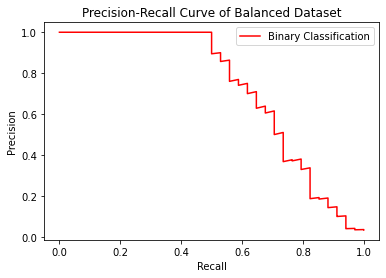

In [21]:
# Plot precision-recall curve for binary classification
precision_binary, recall_binary, _ = precision_recall_curve(y_true_binary, y_scores_binary)
auc_pr = auc(recall_binary, precision_binary)
print("AUC-PR:", auc_pr)

plt.plot(recall_binary, precision_binary, label='Binary Classification', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Neural Network (Balanced Dataset)')
plt.legend()
plt.show()

In [23]:
# Grid search for binary classification
batch_sizes = [8, 16, 32, 64]
learn_rates = [0.1, 0.01, 0.001]

best_binary_model = None
best_binary_val_loss = float('inf')
best_binary_params = {}

for batch_size in batch_sizes:
    for learn_rate in learn_rates:
        train_loader_binary = DataLoader(train_dataset_binary, batch_size=batch_size, shuffle=True)
        val_loader_binary = DataLoader(val_dataset_binary, batch_size=batch_size, shuffle=False)
        test_loader_binary = DataLoader(test_dataset_binary, batch_size=batch_size, shuffle=False)
        
        model = Binary_model(input_dim=X_train_tensor.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learn_rate)
        
        train_losses, _ = train_model(model, criterion, optimizer, train_loader_binary)
        val_losses, _ = validate_model(model, criterion, val_loader_binary)
        
        # Check if the validation loss is less than the current best validation loss. If so, update the best validation loss
        if val_losses < best_binary_val_loss:
            best_binary_val_loss = val_losses
            best_binary_model = model
            best_binary_params['batch_size'] = batch_size
            best_binary_params['learn_rate'] = learn_rate

print(f'Best Validation Loss: {best_binary_val_loss:.4f}, Best Params: {best_binary_params}')

test_model(best_binary_model, criterion_binary, test_loader_binary)
print(f'Best Combination Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Best Validation Loss: 0.2018, Best Params: {'batch_size': 64, 'learn_rate': 0.01}
Best Combination Test Loss: 0.2101, Test Accuracy: 0.9481
